In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

# Change to use continuous adjoint method
# from torchdiffeq import odeint_adjoint as odeint
from torchdiffeq import odeint

import application_examples.helpers.plotting as plt
import application_examples.helpers.training as train

In [2]:
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')

# Learning a linear system
This is a simple example to show how to use the `torchdiffeq` library to learn a linear system of ODEs. We'll explore two different models and compare the results. The first model is neural network with a hidden layer and a non-linear activation function (we'll try two of them). The second model is a simpler neural network with no hidden layers and no activation function. Basically, it is a linear model. This is to show that knowing the structure of the system can help us choose a simpler model that works better.

## Model 1: Can we approximate the vector field with a MLP?

In this section we try with two different neural networks, differing only in the activation function. The frist one uses a tanh activation function and the second one uses a ReLU activation function.

### Hyperparameters

In [3]:
args = {
    'method': 'dopri5',
    'data_size': 5000,
    'batch_time': 20,
    'batch_size': 2500,
    'niters': 100000,
    'test_freq': 1000,
    'terminal_time': 25.,
    'learning_rate': 1e-4,
    'eps': 1e-2,
    'tol': 1
}

### The data

The model needs data to train on. Let's create a linear system that will be used as the underlying system to learn. 

In [4]:
t = torch.linspace(0., args['terminal_time'], args['data_size'])


#### Define the real system
First define the real system, which is a linear system of ODEs with a known solution. Then calculate the solution of the system using the `odeint` function from `torchdiffeq` and plot the solution.

In [5]:
true_y0 = torch.tensor([[2., 0.]])
true_A = torch.tensor([[-0.1, 3.0], [-3.0, -0.1]])

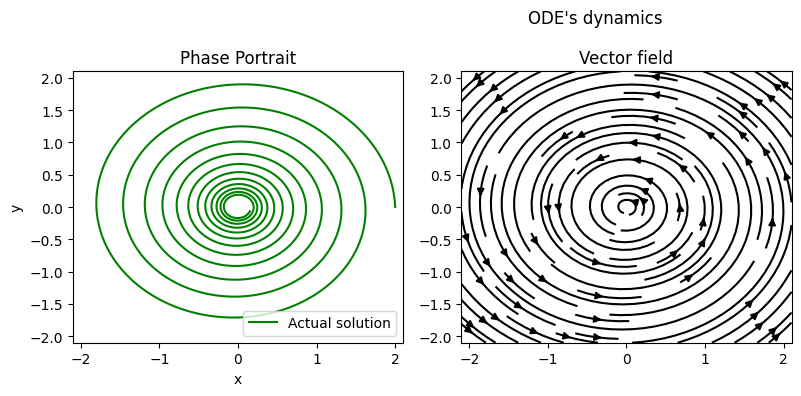

In [6]:
true_vector_field = lambda t, y: torch.mm(y, true_A)
with torch.no_grad():
    true_y = odeint(true_vector_field, true_y0, t, method='dopri5')
plt.plot_ode(true_y, true_vector_field)

### Testing different activation functions

### Tanh

In [7]:
# Define a Neural Network to learn the vector field
class ODEnnT(nn.Module):

    def __init__(self):
        super(ODEnnT, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODEnnT()

#### Train the neural network

In [8]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

losses = train.train_model(func, optimizer, true_y0, true_y, t, args)

Iter 0000 | Total Loss 200.299057
Iter 1000 | Total Loss 94.781990
Iter 2000 | Total Loss 28.226900
Iter 3000 | Total Loss 18.806999
Iter 4000 | Total Loss 13.776367
Iter 5000 | Total Loss 10.891550
Iter 6000 | Total Loss 8.978311
Iter 7000 | Total Loss 8.224165
Iter 8000 | Total Loss 7.271286
Iter 9000 | Total Loss 6.416698
Iter 10000 | Total Loss 6.375987
Iter 11000 | Total Loss 6.237319
Iter 12000 | Total Loss 5.508765
Iter 13000 | Total Loss 5.166094
Iter 14000 | Total Loss 5.514452
Iter 15000 | Total Loss 4.931901
Iter 16000 | Total Loss 4.785769
Iter 17000 | Total Loss 4.621194
Iter 18000 | Total Loss 4.887389
Iter 19000 | Total Loss 4.494218
Iter 20000 | Total Loss 4.182207
Iter 21000 | Total Loss 4.282917
Iter 22000 | Total Loss 4.058842
Iter 23000 | Total Loss 4.211533
Iter 24000 | Total Loss 3.880473
Iter 25000 | Total Loss 4.135308
Iter 26000 | Total Loss 3.337799
Iter 27000 | Total Loss 3.782011
Iter 28000 | Total Loss 4.250800
Iter 29000 | Total Loss 3.467468
Iter 30000 | 

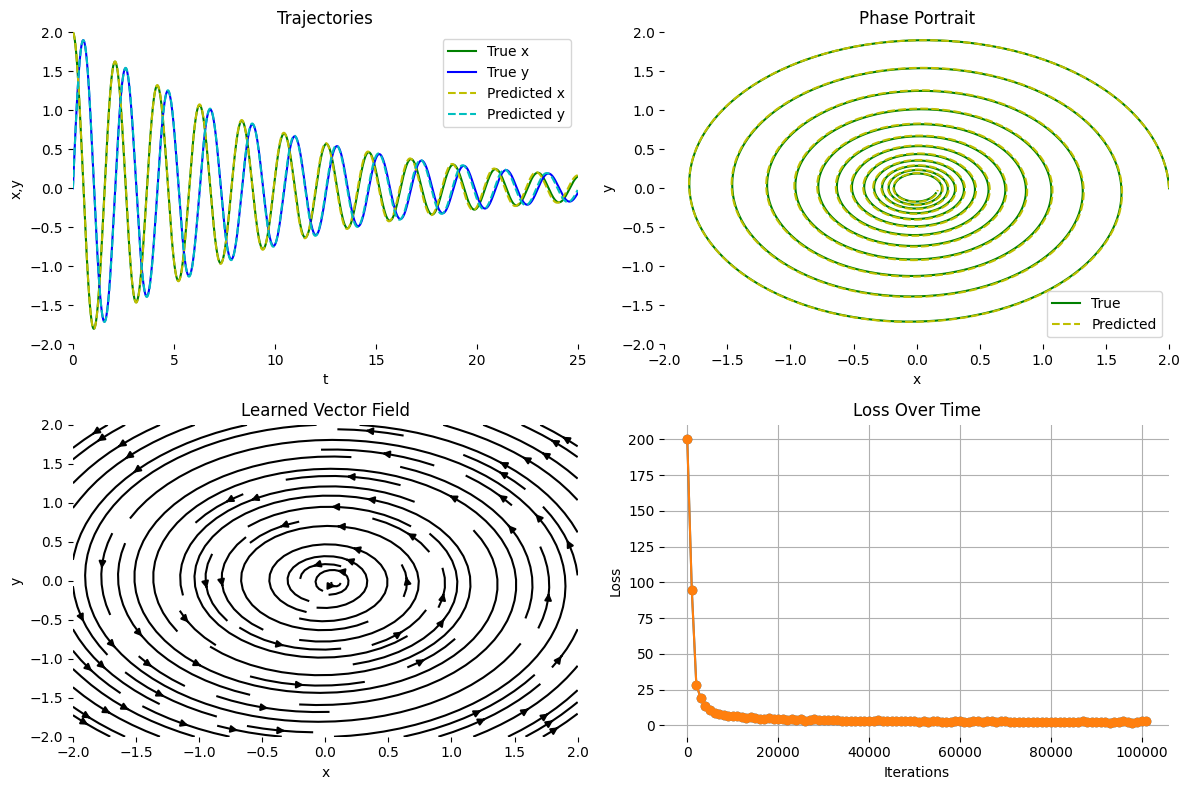

In [9]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=args['method']), t, func, losses, args['test_freq'])

#### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [10]:
# Double time and data points
test_t = torch.linspace(0., 2 * args['terminal_time'], 2 * args['data_size'])

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method='dopri5')

Total Test Loss 1.888768


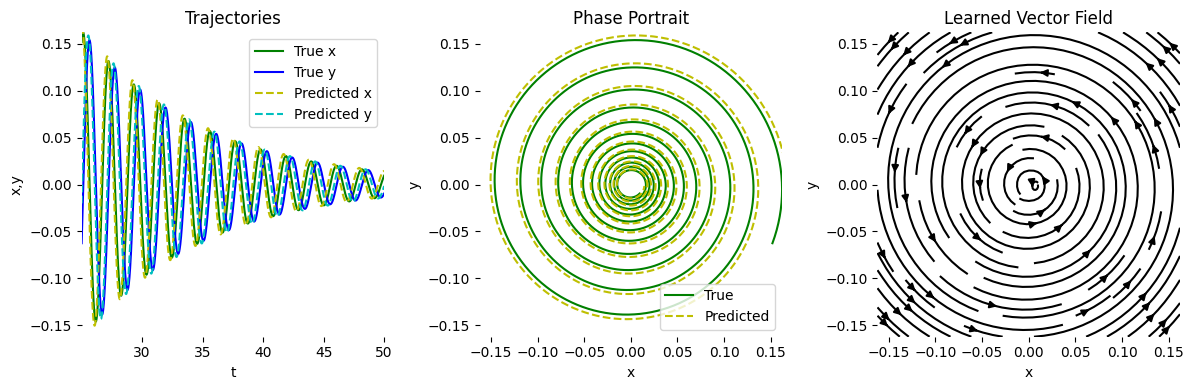

In [11]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=args['method']) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-args['data_size']:] - test_true_y[-args['data_size']:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-args['data_size']:], odeint(func, true_y0, test_t, method=args['method'])[-args['data_size']:], test_t[-args['data_size']:], func)

It is expected that the loss will be smaller because the points are much closer together. However, when looking at the graph one can appreciate the solution goes faster than the actual system.

Actually, it seems the model is not able to learn the vector trajectory of the solution with much precision after some time. 

#### Can the model train with a different initial condition?

In this section we define a different $y_0$ and train the model again.

In [12]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method='dopri5')

In [13]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

new_losses = train.train_model(func, optimizer, new_true_y0, new_true_y, t, args)

Iter 0000 | Total Loss 466.978180
Iter 1000 | Total Loss 176.704529
Iter 2000 | Total Loss 153.573303
Iter 3000 | Total Loss 136.074493
Iter 4000 | Total Loss 120.577438
Iter 5000 | Total Loss 107.852699
Iter 6000 | Total Loss 98.083084
Iter 7000 | Total Loss 90.703804
Iter 8000 | Total Loss 82.444778
Iter 9000 | Total Loss 77.796745
Iter 10000 | Total Loss 70.376411
Iter 11000 | Total Loss 68.316582
Iter 12000 | Total Loss 64.375664
Iter 13000 | Total Loss 57.779373
Iter 14000 | Total Loss 55.027100
Iter 15000 | Total Loss 54.279453
Iter 16000 | Total Loss 49.516243
Iter 17000 | Total Loss 44.927372
Iter 18000 | Total Loss 45.695679
Iter 19000 | Total Loss 35.869946
Iter 20000 | Total Loss 34.093761
Iter 21000 | Total Loss 29.028509
Iter 22000 | Total Loss 23.634542
Iter 23000 | Total Loss 19.858072
Iter 24000 | Total Loss 16.749817
Iter 25000 | Total Loss 14.485183
Iter 26000 | Total Loss 10.798720
Iter 27000 | Total Loss 7.904790
Iter 28000 | Total Loss 7.879328
Iter 29000 | Total L

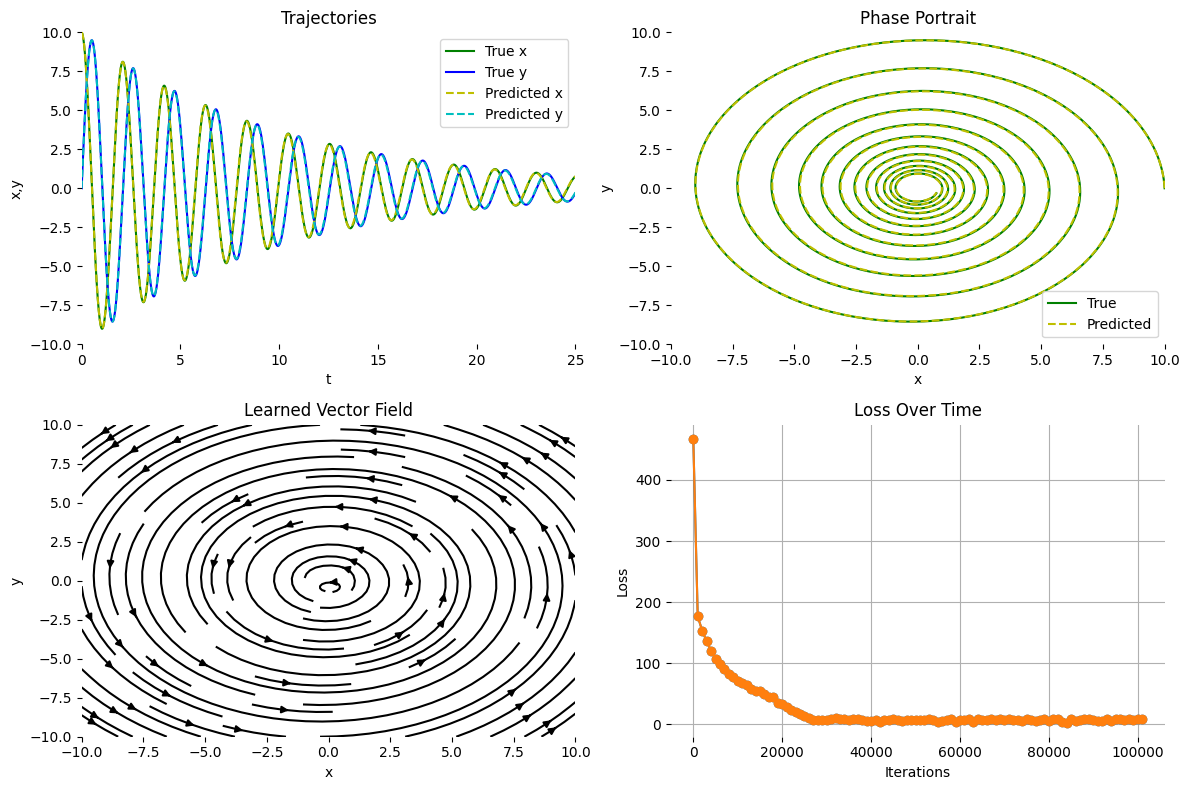

In [14]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method=args['method']), t, func, new_losses, args['test_freq'])

This generalisation has a much higher error than the previous one. This is because the vector field has much larger values in the vicinity of the new initial condition. Not only does this cause the error, in general, to be much larger, but it also makes the system more sensitive to small discrepancies in the predicted points, which add up to a large error. However, when looking at the graph the solution seems to fit rather well. 

### ReLU

In [15]:
# Define a Neural Network to learn the vector field
class ODEnnR(nn.Module):

    def __init__(self):
        super(ODEnnR, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 1 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 50),
            nn.ReLU(),
            nn.Linear(50, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODEnnR()

#### Train the neural network

In [16]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

losses = train.train_model(func, optimizer, true_y0, true_y, t, args)

Iter 0000 | Total Loss 192.384003
Iter 1000 | Total Loss 92.560562
Iter 2000 | Total Loss 84.404495
Iter 3000 | Total Loss 49.015575
Iter 4000 | Total Loss 14.174246
Iter 5000 | Total Loss 1.132975
Iter 6000 | Total Loss 0.380216
Iter 7000 | Total Loss 0.353248
Iter 8000 | Total Loss 0.207105
Iter 9000 | Total Loss 0.223907
Iter 10000 | Total Loss 0.611456
Iter 11000 | Total Loss 0.273799
Iter 12000 | Total Loss 0.322960
Iter 13000 | Total Loss 0.104602
Iter 14000 | Total Loss 0.389669
Iter 15000 | Total Loss 0.178286
Iter 16000 | Total Loss 0.155587
Iter 17000 | Total Loss 0.365984
Iter 18000 | Total Loss 0.236628
Iter 19000 | Total Loss 0.425373
Iter 20000 | Total Loss 0.316689
Iter 21000 | Total Loss 0.226288
Iter 22000 | Total Loss 0.292823
Iter 23000 | Total Loss 0.357653
Iter 24000 | Total Loss 0.134489
Iter 25000 | Total Loss 0.467062
Iter 26000 | Total Loss 0.250432
Iter 27000 | Total Loss 0.451507
Iter 28000 | Total Loss 0.144148
Iter 29000 | Total Loss 0.424312
Iter 30000 | T

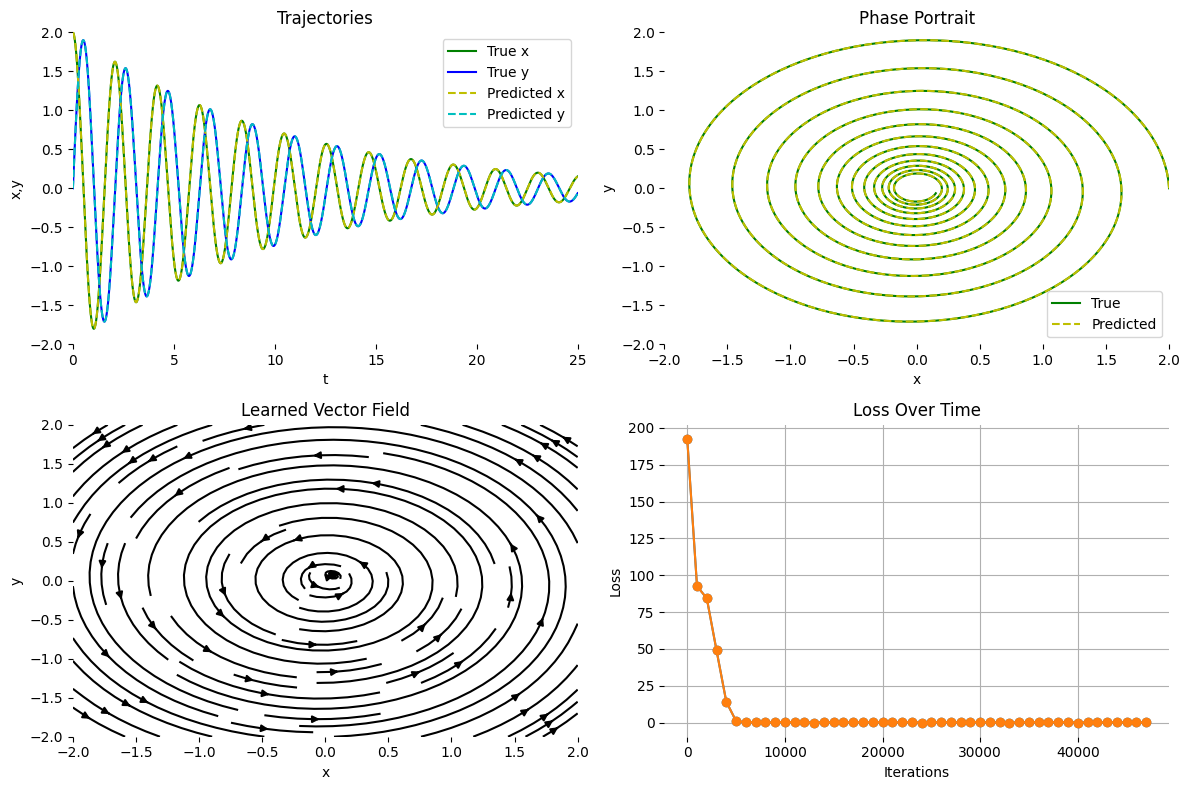

In [17]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=args['method']), t, func, losses, args['test_freq'])

Comparing with the `tanh` model, this one has converged much faster and to a lower error. This seems to indicate that the `ReLU` activation function is better suited for this problem. This makes sense considering the vector field is linear. 

#### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [18]:
# Double time and data points
test_t = torch.linspace(0., 2 * args['terminal_time'], 2 * args['data_size'])

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method='dopri5')

Total Test Loss 0.087709


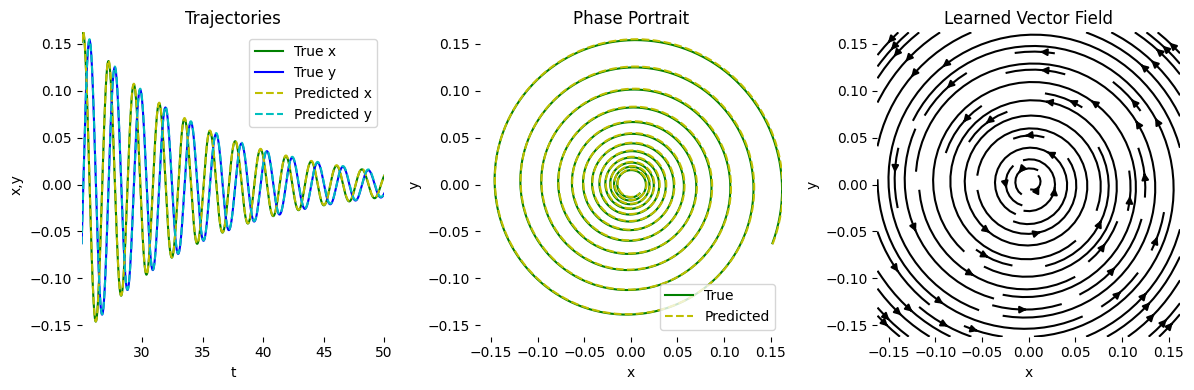

In [19]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=args['method']) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-args['data_size']:] - test_true_y[-args['data_size']:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-args['data_size']:], odeint(func, true_y0, test_t, method=args['method'])[-args['data_size']:], test_t[-args['data_size']:], func)

It is expected that the loss will be smaller because the points are much closer together. This time the solution seems to fit rather well and it doesn't look like it is going faster than the actual system. 

#### Can the model train with a different initial condition?

In this section we define a different $y_0$ and train the model again.

In [20]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method=args['method'])

In [21]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

new_losses = train.train_model(func, optimizer, new_true_y0, new_true_y, t, args)

Iter 0000 | Total Loss 504.146759
Iter 1000 | Total Loss 249.135498
Iter 2000 | Total Loss 172.299347
Iter 3000 | Total Loss 99.069962
Iter 4000 | Total Loss 18.802179
Iter 5000 | Total Loss 2.543246
Iter 6000 | Total Loss 1.377768
Iter 7000 | Total Loss 0.774447
Iter 8000 | Total Loss 0.523497
Iter 9000 | Total Loss 0.362211
Iter 10000 | Total Loss 0.410887
Iter 11000 | Total Loss 0.265185
Iter 12000 | Total Loss 0.184045
Iter 13000 | Total Loss 0.446365
Iter 14000 | Total Loss 0.392818
Iter 15000 | Total Loss 0.259921
Iter 16000 | Total Loss 0.240569
Iter 17000 | Total Loss 0.279387
Iter 18000 | Total Loss 0.307082
Iter 19000 | Total Loss 0.349265
Iter 20000 | Total Loss 0.151537
Iter 21000 | Total Loss 0.136043
Iter 22000 | Total Loss 0.200763
Iter 23000 | Total Loss 0.148860
Iter 24000 | Total Loss 0.172711
Iter 25000 | Total Loss 0.201548
Iter 26000 | Total Loss 0.163447
Iter 27000 | Total Loss 0.167796
Final Loss 0.167796


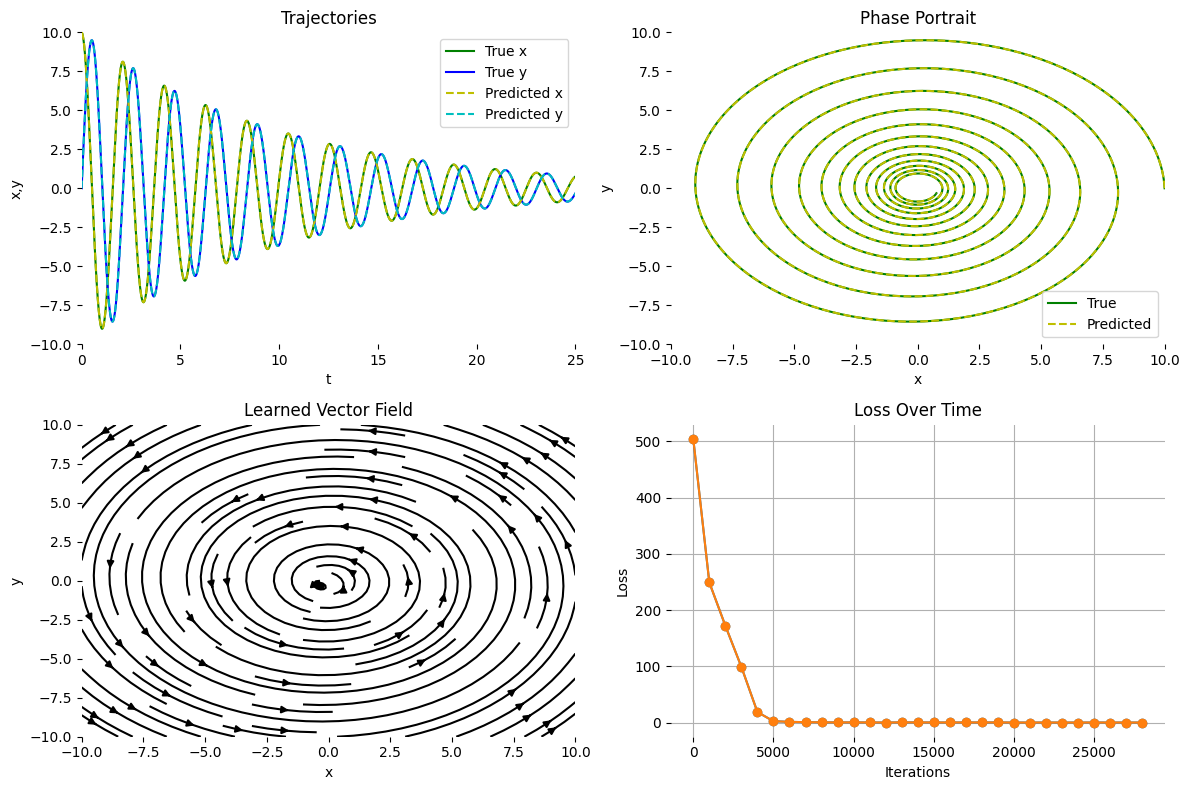

In [22]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method=args['method']), t, func, new_losses, args['test_freq'])

Again, the model has trained much faster and to a lower error than the `tanh` model.

### Results

Having trained both models, we can compare the results. The `ReLU` model has trained much faster and to a lower error than the `tanh` model. Considering the vector field is linear, this makes sense. The `ReLU` activation function is better suited for this problem.

## Model 2: Can we improve the results by simplifying the model?
This is a very simple system. In fact, the vector field we are trying to learn is linear. Therefore, the neural network doesn't need to be able to learn a non-linear function. Let's try to simplify the model by removing the hidden layer and the activation function.

### New hyperparameters

In [63]:
args = {
    'method': 'dopri5',
    'data_size' : 5000,
    'batch_time' : 20,
    'batch_size' : 2500,
    'niters' : 25000,
    'test_freq' : 500,
    'terminal_time' : 25.,
    'learning_rate' : 1e-4,
    'eps': 1e-2,
    'tol': 1
}

### The data

In [64]:
t = torch.linspace(0., args['terminal_time'], args['data_size'])


In [65]:
with torch.no_grad():
    true_y = odeint(true_vector_field, true_y0, t, method='dopri5')

### The model

In [66]:
# Define a Neural Network to learn the vector field
class ODELin(nn.Module):

    def __init__(self):
        super(ODELin, self).__init__()

        self.net = nn.Sequential(
            # ODE-Net's neural network architecture: 2 hidden layer with 50 neurons, tanh activation, 2 output neurons
            nn.Linear(2, 4),
            nn.Linear(4, 2),
        )

        # Initialize the weights and biases of the network for better convergence
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    # Define the forward pass of the network
    def forward(self, t, y):
        return self.net(y)
    
func = ODELin()

#### Train the neural network

In [67]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

losses = train.train_model(func, optimizer, true_y0, true_y, t, args)    

Iter 0000 | Total Loss 221.841934
Iter 0500 | Total Loss 188.243591
Iter 1000 | Total Loss 257.858948
Iter 1500 | Total Loss 327.337769
Iter 2000 | Total Loss 409.233337
Iter 2500 | Total Loss 496.353668
Iter 3000 | Total Loss 600.520691
Iter 3500 | Total Loss 697.169495
Iter 4000 | Total Loss 834.281738
Iter 4500 | Total Loss 1035.286255
Iter 5000 | Total Loss 1148.649048
Iter 5500 | Total Loss 1242.122437
Iter 6000 | Total Loss 791.544617
Iter 6500 | Total Loss 282.907623
Iter 7000 | Total Loss 133.054352
Iter 7500 | Total Loss 107.838936
Iter 8000 | Total Loss 106.732811
Iter 8500 | Total Loss 105.258118
Iter 9000 | Total Loss 97.595749
Iter 9500 | Total Loss 72.140701
Iter 10000 | Total Loss 0.205008
Iter 10500 | Total Loss 0.135201
Iter 11000 | Total Loss 0.157303
Iter 11500 | Total Loss 0.117505
Iter 12000 | Total Loss 0.148399
Iter 12500 | Total Loss 0.143781
Final Loss 0.143781


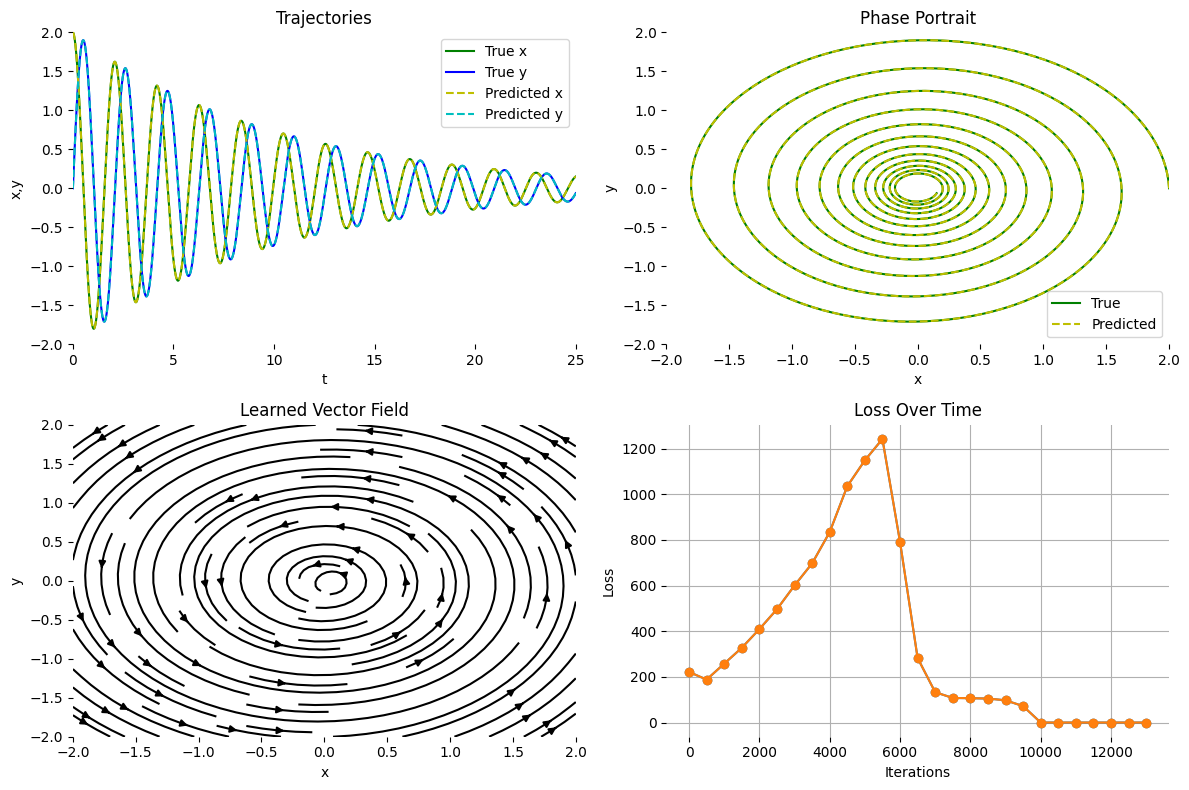

In [68]:
plt.plot_linearODE_result(true_y, odeint(func, true_y0, t, method=args['method']), t, func, losses, args['test_freq'])

#### Generalisation
Now that we have a working model, let's use it to predict from time t=25 to t=50.

In [69]:
# Double time and data points
test_t = torch.linspace(0., 2 * args['terminal_time'], 2 * args['data_size'])

# Compute the real solution
with torch.no_grad():
    test_true_y = odeint(true_vector_field, true_y0, test_t, method=args['method'])

Total Test Loss 0.053913


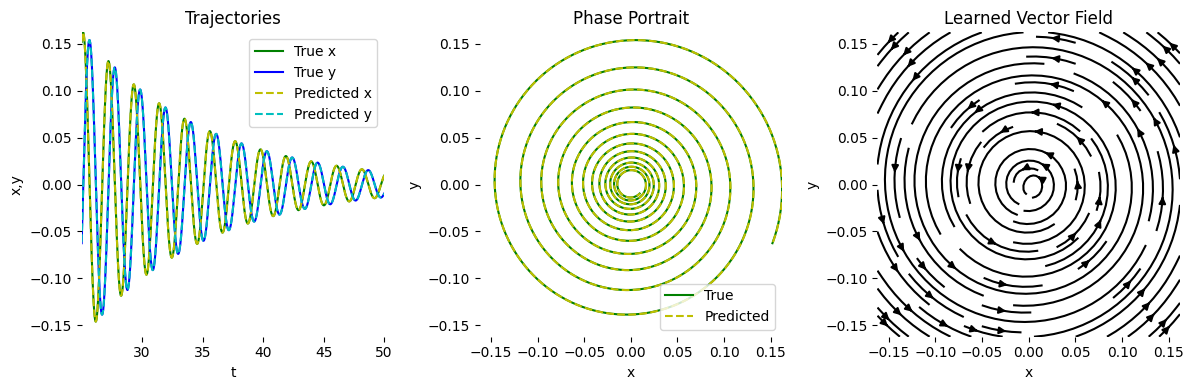

In [70]:
# Compute loss using all new data
test_pred_y = odeint(func, true_y0, test_t, method=args['method']) # func is the same model
# Loss of the new points
loss = torch.norm(test_pred_y[-args['data_size']:] - test_true_y[-args['data_size']:])
print('Total Test Loss {:.6f}'.format(loss.item()))
plt.plot_linearODE_result(test_true_y[-args['data_size']:], odeint(func, true_y0, test_t, method=args['method'])[-args['data_size']:], test_t[-args['data_size']:], func)

It is expected that the loss will be smaller because the points are much closer together. This time the solution seems to fit rather well and it doesn't look like it is going faster than the actual system. 

### Try it with a different initial condition

In [71]:
new_true_y0 = torch.tensor([[10., 0.]])

with torch.no_grad():
    new_true_y = odeint(true_vector_field, new_true_y0, t, method='dopri5')

In [72]:
optimizer = optim.RMSprop(func.parameters(), lr=args['learning_rate'])

new_losses = train.train_model(func, optimizer, new_true_y0, new_true_y, t, args)

Iter 0000 | Total Loss 0.714123
Iter 0500 | Total Loss 0.217210
Iter 1000 | Total Loss 0.644548
Iter 1500 | Total Loss 0.720749
Iter 2000 | Total Loss 0.876101
Iter 2500 | Total Loss 0.800259
Iter 3000 | Total Loss 0.772255
Iter 3500 | Total Loss 0.587202
Iter 4000 | Total Loss 0.484432
Iter 4500 | Total Loss 0.571687
Iter 5000 | Total Loss 0.814527
Iter 5500 | Total Loss 0.649051
Iter 6000 | Total Loss 0.320153
Iter 6500 | Total Loss 0.765904
Iter 7000 | Total Loss 0.539429
Iter 7500 | Total Loss 0.729877
Iter 8000 | Total Loss 0.824507
Iter 8500 | Total Loss 0.408935
Iter 9000 | Total Loss 0.555290
Iter 9500 | Total Loss 0.536934
Iter 10000 | Total Loss 0.342325
Iter 10500 | Total Loss 0.648471
Iter 11000 | Total Loss 0.671023
Iter 11500 | Total Loss 0.681533
Iter 12000 | Total Loss 0.754511
Iter 12500 | Total Loss 0.498219
Iter 13000 | Total Loss 0.184787
Iter 13500 | Total Loss 0.916044
Iter 14000 | Total Loss 0.493327
Iter 14500 | Total Loss 0.681566
Iter 15000 | Total Loss 0.5796

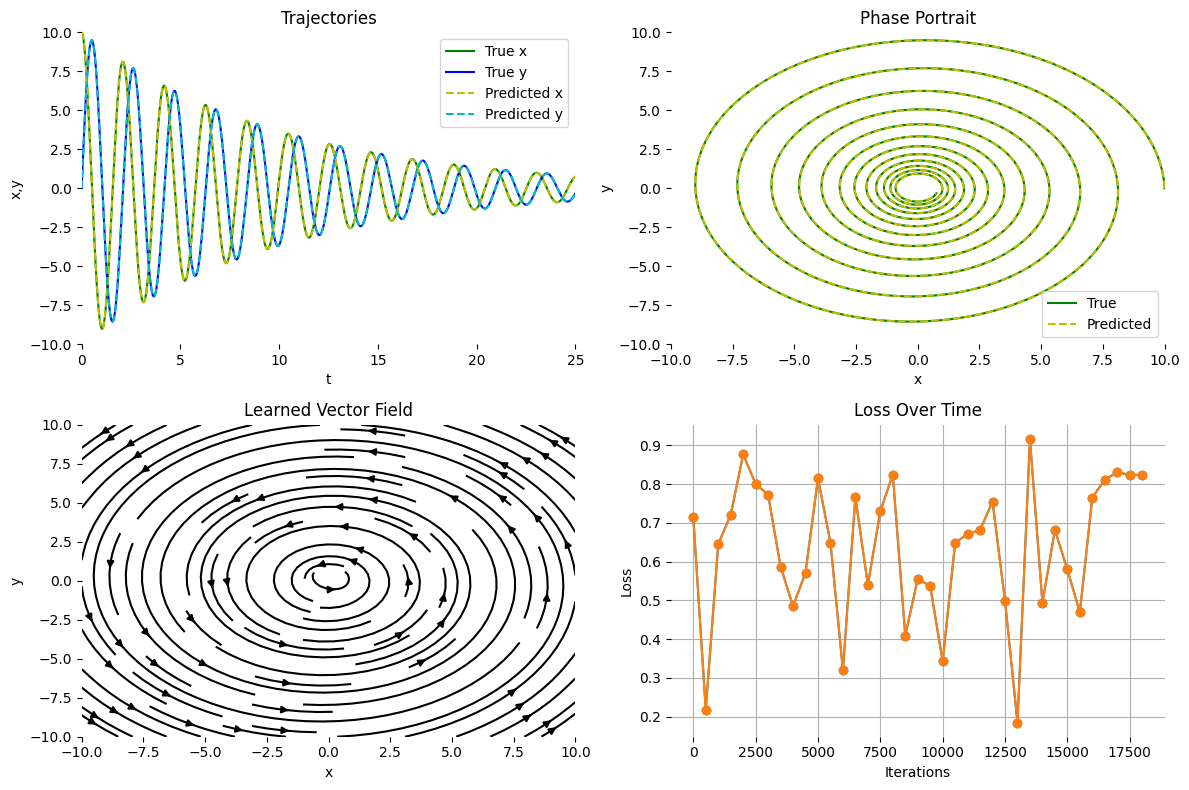

In [73]:
plt.plot_linearODE_result(new_true_y, odeint(func, new_true_y0, t, method='dopri5'), t, func, new_losses, args['test_freq'])

### Results
While the error is similar to the `ReLU` model, the training has been much faster, but a lot more unstable. A remarkable difference is that the model already starts with a very low loss when learning a different initial condition. This seems to indicate that when learning the vector field, the linear model has learnt the general structure of the field, while the MLPs have learnt only the area where they were trained.

## Conclusion

### Result comparison
| Model  | Training iterations | Training loss | Generalisation loss | Starting loss new init. cond. | Final loss new init. cond. |
|--------|---------------------|---------------|---------------------|-------------------------------|----------------------------|
| Tanh   | 100000              | 2.738999      | 1.888768            | 466.978180                    | 9.166912                   |
| ReLU   | 46000               | 0.197018      | 0.087709            | 504.146759                    | 0.167796                   |
| Linear | 12500               | 0.143781      | 0.053913            | 0.714123                      | 0.823650                   |

It is evident that the linear model has trained much faster and to a lower error than the MLPs. However, the difference between the ReLU model and the linear model is insignificant for the first two metrics. The real difference is in the generalisation. The linear model has learnt the general structure of the vector field, while the MLPs have learnt only the area where they were trained. This is clear when looking at the starting loss when learning a different initial condition. The linear model has a very low loss, while the MLPs have a very high loss. This indicates that if we wish for a model that learns the dynamics of the system regardless of where it's trained, the linear model is the best choice. However, when training specifically for a certain area, the MLPs are better suited for the task, as it can be seen in the final loss when learning a different initial condition for the `ReLU` model.

Furthermore, simple neural networks have the capacity to approximate any function, which makes them the best candidates when trying to learn the voctor field of a system, even if we know its structure. This comes at the cost of longer training times, and more data. The data constraint is not a problem in this case, as we can generate as much data as we need.